# Iris Classification: Data Analysis and Machine Learning in Python

## Purpose statement

*Defined problem*: classification<br>
We will attempt to classify the species of an iris flower based on measurments included in the *iris dataset*.

*Success metric*: model prediction accuracy<br>
With our classification goal, we can use model accuracy to determine success of our model.

*Pipeline*: for web<br>
Our data analysis is only one part of a larger pipeline for a public-facing website that will be able to classify species of flower based on uploaded images.

## Import required libraries
The following libraries will be used in this analysis:
<ul>
    <li><b>Numpy</b>: Adds numerical arrays and helper functions.</li>
    <li><b>Pandas</b>: Adds dataframe structure to more easily and efficiently work with data.</li>
    <li><b>scikit-learn</b>: Machine Learning for Python.</li>
    <li><b>matplotlib</b>: Pyplot module for basic plotting of dataframes.</li>
    <li><b>Seaborn</b>: Statistical plotting library.</li>
</ul>

In [1]:
# data libraries
import pandas as pd
import numpy as np
import datetime as dt
import time

# machine learning libraries
from scipy import stats
from scipy.stats import randint
from sklearn import model_selection, metrics, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# from catboost import CatBoostClassifier, Pool, cv

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## EDA - Cleaning, exploring, plotting, and tidying

<ul>
    <li>What type of data are we dealing with?</li>
    <li>How much cleaning will be necessary to make the data useful?</li>
    <li>Any missing values?</li>
</ul>

In [2]:
iris = pd.read_csv('iris.csv')
iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


In [3]:
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

The data is already in a useable format. The first row contains the headers, which are descriptive and in an easy format to use dot notation. Our single categorical column (species) contains three unique values--setosa, versicolor, and virginica.

**We should immediately check for missing values** so that doesn't bite us later. When using pandas dataframes, I like to use *.info()* to get the shape of the dataframe, count of nulls, and dtypes simultaneously.

In [4]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


*Nice!* No missing values and data is formatted appropriately.

**Next we should get to know our data.** The best way to get an initial impression of data is to visualize it. I will use seaborn's pairplot to visualize the distribution of data for each variable. Because our goal is to classify the species, I will set that variable as our *hue*.

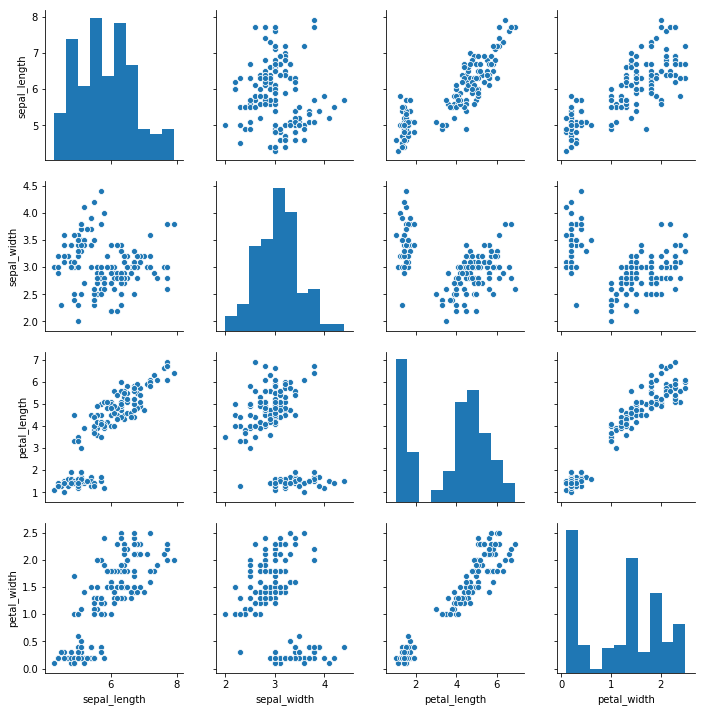

In [5]:
sns.pairplot(iris)
plt.show()

Overall, our data seems to be normally distributed, which gives us more options of models we can run on the data. The first thing that clearly jumps out is that it seems we have two clusters of data, which is likely an iris species that is different from the other two. Let's replot the data by species to see.

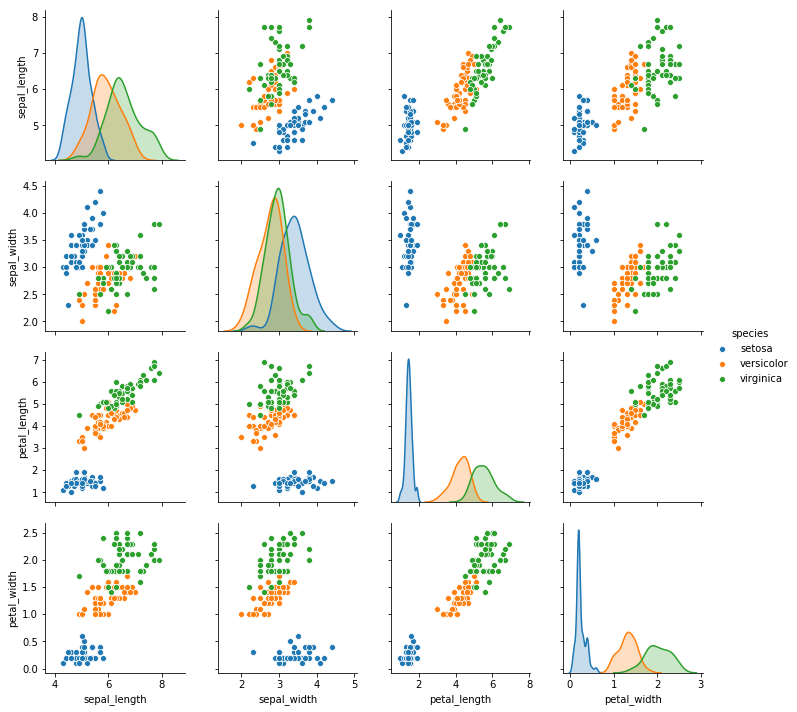

In [6]:
sns.pairplot(iris, hue = 'species')
plt.show()

We've confirmed that the *setosa* species is easily-distinguishable from the versicolor and viginica species. However, it does seem like there may be an outlier or two within the iris-setosa data. We should dig deeper into each species to check for outliers.

**Dealing with outliers:**
Nearly every data set is going to have outliers, and there are a plethora of reasons they can appear. Knowing this, it will be extremely important to handle them judiciously, and document any changes or exclusions with solid explanations for your decision. 

We can quickly get some high-level statistical data with *.describe()* and then use matplotlib and seaborn to visualize our variable data by species using a boxplot.

In [7]:
desc_setosa = iris[iris.species=='setosa'].describe()
desc_versicolor = iris[iris.species=='versicolor'].describe()
desc_virginica = iris[iris.species=='virginica'].describe()

print(f"""
==Setosa==
{desc_setosa}

==Versicolor==
{desc_versicolor}

==Virginica==
{desc_virginica}
""")


==Setosa==
       sepal_length  sepal_width  petal_length  petal_width
count      50.00000    50.000000     50.000000    50.000000
mean        5.00600     3.428000      1.462000     0.246000
std         0.35249     0.379064      0.173664     0.105386
min         4.30000     2.300000      1.000000     0.100000
25%         4.80000     3.200000      1.400000     0.200000
50%         5.00000     3.400000      1.500000     0.200000
75%         5.20000     3.675000      1.575000     0.300000
max         5.80000     4.400000      1.900000     0.600000

==Versicolor==
       sepal_length  sepal_width  petal_length  petal_width
count     50.000000    50.000000     50.000000    50.000000
mean       5.936000     2.770000      4.260000     1.326000
std        0.516171     0.313798      0.469911     0.197753
min        4.900000     2.000000      3.000000     1.000000
25%        5.600000     2.525000      4.000000     1.200000
50%        5.900000     2.800000      4.350000     1.300000
75%        6

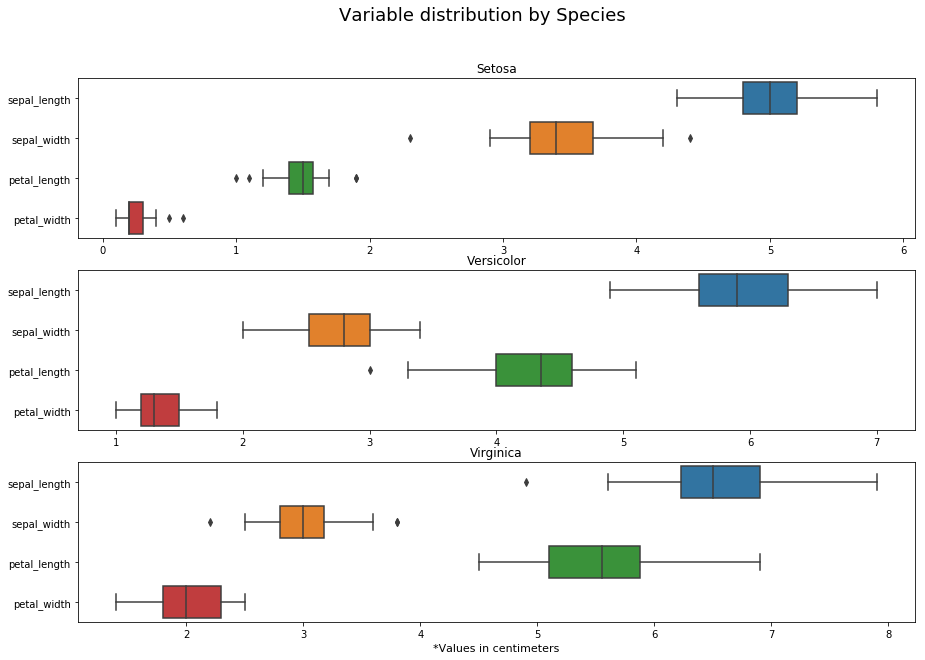

In [8]:
f, axs = plt.subplots(1,3, figsize=(15, 10))
f.suptitle('Variable distribution by Species', fontsize=18)

plt.subplot(3,1,1)
sns.boxplot(data=iris[iris.species=='setosa'], orient='h')
plt.title('Setosa')

plt.subplot(3,1,2)
sns.boxplot(data=iris[iris.species=='versicolor'], orient='h')
plt.title('Versicolor')

plt.subplot(3,1,3)
sns.boxplot(data=iris[iris.species=='virginica'], orient='h')
plt.title('Virginica')

plt.xlabel('*Values in centimeters', fontsize=11)
# plt.tight_layout()
plt.show()

**The grouped boxplot** is a perfect way to visualize our data for each variable in each species. Boxplots are a visual representation of the summary statistics from the *.describe()* above. However, they also highlight outliers.

>**Need to know**: Boxplots show "minimum", first quartile, median, third quartile, and "maximum". The *box* in a boxplot is the IQR (inter-quartile range), which is the distance between the 25th-percentile (first quartile) and 75th-percentile (third quartile). The median is represented by a line somewhere inside the colored box. Outliers are represented as dots outside the "minimum" or "maximum" range, which are set equal to the value that is 1.5 times the IQR outside of the IQR.

Our boxplot is telling us that we have outliers; however, an issue with any measure of standard deviation in a dataset this small is that you are likely to assume too many values are outliers. 

Let's look at the observed petal lengths for setosa species, which looks to have 3 outliers based on the boxplot above.

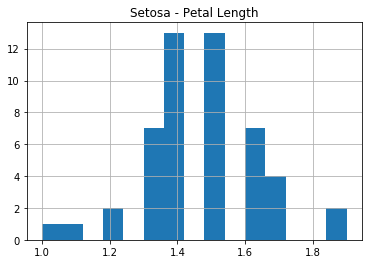

In [9]:
iris[iris.species=='setosa']['petal_length'].hist(bins=15)
plt.title('Setosa - Petal Length')
plt.show()

Based on the above histogram, I wouldn't call any of these values outliers. The distribution is fairly normal, and there are actually two observations just above 1.8cm. In a dataset this small, two observations are too many to be considered an outlier.

Let's compare this histogram to one for setosa sepal width.

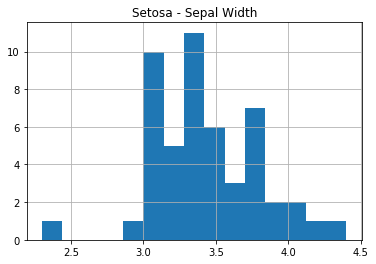

In [10]:
iris[iris.species=='setosa']['sepal_width'].hist(bins=15)
plt.title('Setosa - Sepal Width')
plt.show()

Unlike before, we have an obvious outlier below 2.5cm, we will need to take care of this one. This observation could be an typo in the dataset, an odd actual observation, or any number of other reasons. Because the actual reason for this observation would be nearly impossible to figure out, we should just remove it. Below is the observation we will remove.

>**A note on excluding outliers:** This observation can be safely excluded; however, in datasets where one observation has an affect on other observations (such as time-series data) there may be better processes of dealing with outliers.

In [11]:
print("===Observation to Drop===")
iris[(iris.species == 'setosa')&(iris.sepal_width <= 2.5)]

===Observation to Drop===


,sepal_length,sepal_width,petal_length,petal_width,species
41,4.5,2.3,1.3,0.3,setosa


We will keep note of this as we check the other variables. Now let's check the Versicolor petal length.

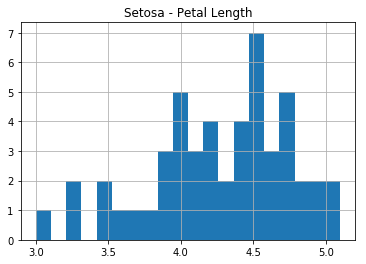

In [12]:
iris[iris.species=='versicolor']['petal_length'].hist(bins=20)
plt.title('Setosa - Petal Length')
plt.show()

In [13]:
print("==Smallest Versicolor Petal Length Observations==")
iris[iris.species=='versicolor']['petal_length'].sort_values()[:4]

==Smallest Versicolor Petal Length Observations==


98    3.0
93    3.3
57    3.3
79    3.5
Name: petal_length, dtype: float64

It doesn't seem to be an outlier. The data does suggest that most values are above 4.0cm, far more variance exists in the smaller versicolor observations. Unless we had some domain knowledge we could use to make a more-informed decision here, we're going to leave it for now.

For the last species, virginica, we should check the sepal length and width.

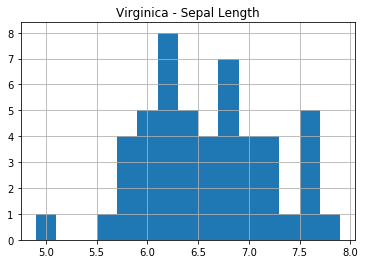

In [14]:
iris[iris.species=='virginica']['sepal_length'].hist(bins=15)
plt.title('Virginica - Sepal Length')
plt.show()

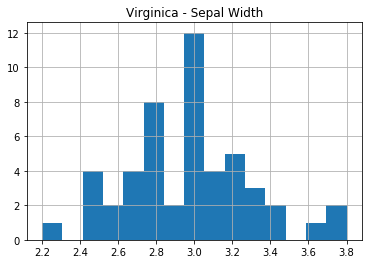

In [15]:
iris[iris.species=='virginica']['sepal_width'].hist(bins=15)
plt.title('Virginica - Sepal Width')
plt.show()

In [16]:
print("==Smallest Virginica Sepal Length Observations==")
iris[iris.species=='virginica']['sepal_length'].sort_values()[:4]

==Smallest Virginica Sepal Length Observations==


106    4.9
121    5.6
113    5.7
101    5.8
Name: sepal_length, dtype: float64

In [17]:
print("==Smallest Virginica Sepal Width Observations==")
iris[iris.species=='virginica']['sepal_width'].sort_values()[:4]

==Smallest Virginica Sepal Width Observations==


119    2.2
108    2.5
113    2.5
106    2.5
Name: sepal_width, dtype: float64

It's never ideal to exclude data, but in this case I believe that observation 106, a Virginica with sepal length of 4.9, is likely an outlier.

In [18]:
print("===Observation to Drop===")
iris[(iris.species == 'virginica')&(iris.sepal_length <= 4.9)]

===Observation to Drop===


,sepal_length,sepal_width,petal_length,petal_width,species
106,4.9,2.5,4.5,1.7,virginica


Now we will **exclude outliers** by dropping the two observations we have confirmed from both the boxplot and the histogram. I will create a copy of our *iris* dataframe called *iris_o*. 

I've developed a personal habit of copying dataframes to exclude outliers and add *_o* to the dataframe name--for "outlier," of course. Then we can use another *.info()* or even just a *len()* to confirm we have dropped two observations.



In [19]:
#>**Important Note:** When dropping observations from a dataframe, first ensure you set *inplace=True* so that you are actually dropping from the dataframe instead of simply viewing the dataframe with the observations dropped.<br> 
#>Secondly, make note to *reset_index(inplace=True)* or you will have many issues with your analysis. If you forget to reset the index, you will have an index range larger than the number of observations. In our case, that would mean that our index would remain 0 through 149 even though we will only have 148 observation (a range of 0 through 147) after dropping our two outliers.

In [20]:
to_drop = [41, 106]

iris_o = iris.drop(to_drop, axis=0)
iris_o.reset_index(drop=True, inplace=True)

In [21]:
print(f"""
iris DF Length: {len(iris)}
iris_o DF Length: {len(iris_o)}
dropped observations: {len(iris)-len(iris_o)}
""")


iris DF Length: 150
iris_o DF Length: 148
dropped observations: 2



In [22]:
iris_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 5 columns):
sepal_length    148 non-null float64
sepal_width     148 non-null float64
petal_length    148 non-null float64
petal_width     148 non-null float64
species         148 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


Dropped observations and index range reset confirmed! Now that we have clean data with no missing values or outliers, we can visualize our final tidied data and start our analysis.

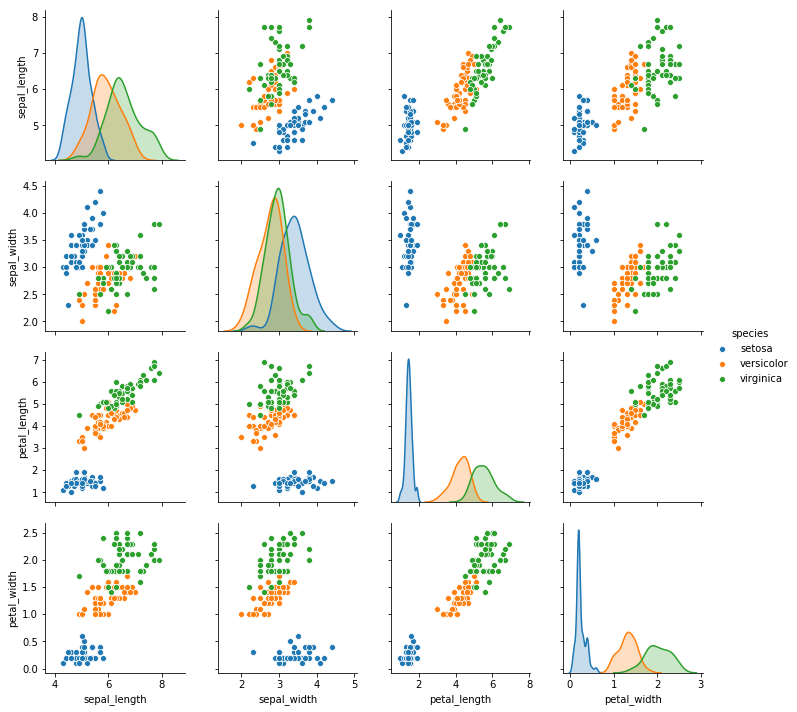

In [23]:
sns.pairplot(iris, hue='species')
plt.show()

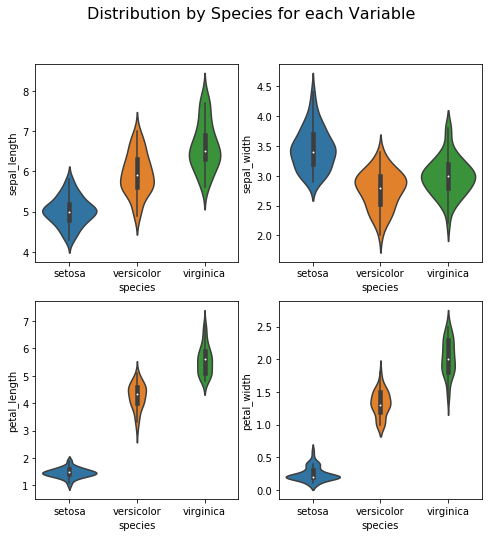

In [24]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
sns.violinplot(x='species', y='sepal_length', data=iris_o)

plt.subplot(2,2,2)
sns.violinplot(x='species', y='sepal_width', data=iris_o)

plt.subplot(2,2,3)
sns.violinplot(x='species', y='petal_length', data=iris_o)

plt.subplot(2,2,4)
sns.violinplot(x='species', y='petal_width', data=iris_o)

plt.suptitle('Distribution by Species for each Variable', fontsize=16)
plt.show()

In [25]:
iris_o.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.151050,0.877678,0.826171
sepal_width,-0.151050,1.000000,-0.451582,-0.382739
petal_length,0.877678,-0.451582,1.000000,0.962716
petal_width,0.826171,-0.382739,0.962716,1.000000


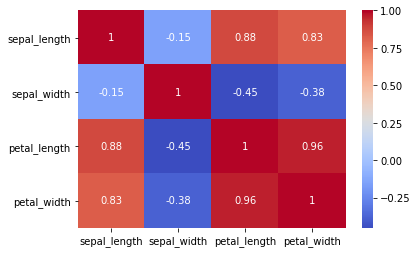

In [26]:
sns.heatmap(iris_o.corr(), annot=True, cmap='coolwarm')

## Classification
We started with a fairly clean dataset, made a few positive improvements by removing outliers, and got a little more acquainted with our data in EDA. Now we can finally get to the fun part and actually do some modelling! Tidying and exploring data can be a tiresome task, but the algorithms aren't going to fix bad data. Machine Learning definitely fits the *garbage in...garbage out* adage.

In [27]:
# train, test split 

# logistic regression
# knn
# gaussain naive bayes
# linear support vector machines
# stochastic gradient decent
# decision tree classifier
# gradient boost
# catboost
# grid search
# watermark


### Train, test split
The next step will be splitting our data into a **training set** and a **testing set**. The training set is a random sample of data that we will use to train our models. The testing set is also random and will include data excluded from the training set to be used for validation. We do this to ensure that we don't *overfit* our model to the data we already have at the expense of the new data we want it to classify.

Before splitting, we need to define X and y variables. In our dataset, the y-variable (also: target variable) is *species*, because that is the variable we are trying to predict. All other variables will be X variables.

In [44]:
from sklearn.model_selection import train_test_split

X = iris_o.drop('species', axis=1)
y = iris_o['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Algorithm fit and measure function

While it is completely appropriate to run variables and measure each, we can also define a function to expedite the prediction and measurement of each model.

In [45]:
# def fit_algo(algo, X_train, y_train, cv):
    
#     # Single Pass
#     model = algo.fit(X_train, y_train)
#     acc = round(model.score(X_train, y_train) * 100, 2)
    
#     # CV
#     train_pred = model_selection.cross_val_predict(algo,
#                                                   X_train,
#                                                   y_train,
#                                                   cv=cv,
#                                                   n_jobs = -1)
    
#     # CV accuracy
#     acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
       
#     return train_pred, acc, acc_cv

In [46]:
def fit_algo(algo, X_train, y_train, X_test, cv):
    
    # Single pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression,
                         KNeighborsClassifier,
                         GaussianNB,
                         DecisionTreeClassifier,
                         RandomForestClassifier,
                         GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "N/A"
    acc = round(model.score(X_test, y_test) * 100, 2)
    
    #CV
    train_pred = model_selection.cross_val_predict(algo,
                                                  X_train,
                                                  y_train,
                                                  cv=cv,
                                                  n_jobs=-1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

### Multi-nomial Logistic Regression

In [47]:
start = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_algo(
    LogisticRegression(
        solver='newton-cg',
        multi_class='multinomial'),
    X_train,
    y_train,
    X_test,
    10)

log_time = (time.time() - start)

print(f"""
===Accuracy Metrics===
Accuracy: {acc_log}
Accuracy CV-10: {acc_cv_log}
TTC: {dt.timedelta(seconds=log_time)}


===Training Report===
Training Confusion Matrix: 
{confusion_matrix(y_train, train_pred_log)}

Training Classification Report:
{classification_report(y_train, train_pred_log)}


===Testing Report===
{confusion_matrix(y_test, test_pred_log)}

Testing Classification Report:
{classification_report(y_test, test_pred_log)}
""")


===Accuracy Metrics===
Accuracy: 97.78
Accuracy CV-10: 96.12
TTC: 0:00:00.113668


===Training Report===
Training Confusion Matrix: 
[[32  0  0]
 [ 0 35  2]
 [ 0  2 32]]

Training Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       0.95      0.95      0.95        37
   virginica       0.94      0.94      0.94        34

   micro avg       0.96      0.96      0.96       103
   macro avg       0.96      0.96      0.96       103
weighted avg       0.96      0.96      0.96       103



===Testing Report===
[[17  0  0]
 [ 0 12  1]
 [ 0  0 15]]

Testing Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        17
  versicolor       1.00      0.92      0.96        13
   virginica       0.94      1.00      0.97        15

   micro avg       0.98      0.98      0.98        45
   macro avg       0.98      0.97      0.98        

### K-nearest neighbors

In [48]:
start = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_algo(KNeighborsClassifier(n_neighbors=5,
                                                                                             n_jobs=-1),
                                                                         X_train,
                                                                         y_train,
                                                                         X_test,
                                                                         10)

knn_time = (time.time() - start)

print(f"""
===Accuracy Metrics===
Accuracy: {acc_knn}
Accuracy CV-10: {acc_cv_knn}
TTC: {dt.timedelta(seconds=knn_time)}


===Training Report===
Confusion Matrix: 
{confusion_matrix(y_train, train_pred_knn)}

Classification Report:
{classification_report(y_train, train_pred_knn)}


===Testing Report===
Confusion Matrix: 
{confusion_matrix(y_test, test_pred_knn)}

Classification Report:
{classification_report(y_test, test_pred_knn)}
""")


===Accuracy Metrics===
Accuracy: 97.78
Accuracy CV-10: 97.09
TTC: 0:00:00.745999


===Training Report===
Confusion Matrix: 
[[32  0  0]
 [ 0 34  3]
 [ 0  0 34]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       1.00      0.92      0.96        37
   virginica       0.92      1.00      0.96        34

   micro avg       0.97      0.97      0.97       103
   macro avg       0.97      0.97      0.97       103
weighted avg       0.97      0.97      0.97       103



===Testing Report===
Confusion Matrix: 
[[17  0  0]
 [ 0 12  1]
 [ 0  0 15]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        17
  versicolor       1.00      0.92      0.96        13
   virginica       0.94      1.00      0.97        15

   micro avg       0.98      0.98      0.98        45
   macro avg       0.98      0.97      0.98        45
weig

### Gaussian Naive Bayes

In [49]:
start = time.time()
train_pred_gnb, test_pred_gnb, acc_gnb, acc_cv_gnb, probs_gnb = fit_algo(GaussianNB(),
                                                                         X_train,
                                                                         y_train,
                                                                         X_test,
                                                                         10)

gnb_time = (time.time() - start)

print(f"""
===Accuracy Metrics===
Accuracy: {acc_gnb}
Accuracy CV-10: {acc_cv_gnb}
TTC: {dt.timedelta(seconds=gnb_time)}


===Training Report===
Confusion Matrix: 
{confusion_matrix(y_train, train_pred_gnb)}

Classification Report:
{classification_report(y_train, train_pred_gnb)}


===Test Report===
Confusion Matrix: 
{confusion_matrix(y_test, test_pred_gnb)}

Classification Report:
{classification_report(y_test, test_pred_gnb)}
""")


===Accuracy Metrics===
Accuracy: 97.78
Accuracy CV-10: 95.15
TTC: 0:00:00.044879


===Training Report===
Confusion Matrix: 
[[32  0  0]
 [ 0 34  3]
 [ 0  2 32]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       0.94      0.92      0.93        37
   virginica       0.91      0.94      0.93        34

   micro avg       0.95      0.95      0.95       103
   macro avg       0.95      0.95      0.95       103
weighted avg       0.95      0.95      0.95       103



===Test Report===
Confusion Matrix: 
[[17  0  0]
 [ 0 13  0]
 [ 0  1 14]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        17
  versicolor       0.93      1.00      0.96        13
   virginica       1.00      0.93      0.97        15

   micro avg       0.98      0.98      0.98        45
   macro avg       0.98      0.98      0.98        45
weighte

### Linear SVC

In [50]:
start = time.time()
train_pred_svc, test_pred, acc_svc, acc_cv_svc, probs = fit_algo(LinearSVC(),
                                                                      X_train,
                                                                      y_train,
                                                                      X_test,
                                                                      10)

svc_time = (time.time() - start)

print(f"""
===Accuracy Metrics===
Accuracy: {acc_svc}
Accuracy CV-10: {acc_cv_svc}
TTC: {dt.timedelta(seconds=svc_time)}


===Training Report===
Confusion Matrix: 
{confusion_matrix(y_train, train_pred_svc)}

Classification Report:
{classification_report(y_train, train_pred_svc)}


===Training Report===
TTC: {dt.timedelta(seconds=svc_time)}

Confusion Matrix: 
{confusion_matrix(y_train, train_pred_svc)}

Classification Report:
{classification_report(y_train, train_pred_svc)}
""")


===Accuracy Metrics===
Accuracy: 93.33
Accuracy CV-10: 96.12
TTC: 0:00:00.077793


===Training Report===
Confusion Matrix: 
[[32  0  0]
 [ 0 35  2]
 [ 0  2 32]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       0.95      0.95      0.95        37
   virginica       0.94      0.94      0.94        34

   micro avg       0.96      0.96      0.96       103
   macro avg       0.96      0.96      0.96       103
weighted avg       0.96      0.96      0.96       103



===Training Report===
TTC: 0:00:00.077793

Confusion Matrix: 
[[32  0  0]
 [ 0 35  2]
 [ 0  2 32]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       0.95      0.95      0.95        37
   virginica       0.94      0.94      0.94        34

   micro avg       0.96      0.96      0.96       103
   macro avg       0.96      0.96   

C:\Users\derrickg\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Stochastic Gradient Descent

In [51]:
start = time.time()
train_pred_sgdc, test_pred_sgdc, acc_sgdc, acc_cv_sgdc, probs = fit_algo(SGDClassifier(n_jobs=-1,
                                                                                      tol=None,
                                                                                      shuffle=True,
                                                                                      max_iter=1000),
                                                                         X_train,
                                                                         y_train,
                                                                         X_test,
                                                                         10)

sgdc_time = (time.time() - start)

print(f"""
===Accuracy Metrics===
Accuracy: {acc_sgdc}
Accuracy CV-10: {acc_cv_sgdc}
TTC: {dt.timedelta(seconds=sgdc_time)}


===Training Report===
Confusion Matrix: 
{confusion_matrix(y_train, train_pred_sgdc)}

Classification Report:
{classification_report(y_train, train_pred_sgdc)}


===Training Report===
Confusion Matrix: 
{confusion_matrix(y_test, test_pred_sgdc)}

Classification Report:
{classification_report(y_test, test_pred_sgdc)}
""")

C:\Users\derrickg\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)



===Accuracy Metrics===
Accuracy: 95.56
Accuracy CV-10: 93.2
TTC: 0:00:00.551356


===Training Report===
Confusion Matrix: 
[[29  3  0]
 [ 1 36  0]
 [ 0  3 31]]

Classification Report:
              precision    recall  f1-score   support

      setosa       0.97      0.91      0.94        32
  versicolor       0.86      0.97      0.91        37
   virginica       1.00      0.91      0.95        34

   micro avg       0.93      0.93      0.93       103
   macro avg       0.94      0.93      0.93       103
weighted avg       0.94      0.93      0.93       103



===Training Report===
Confusion Matrix: 
[[17  0  0]
 [ 1 12  0]
 [ 0  1 14]]

Classification Report:
              precision    recall  f1-score   support

      setosa       0.94      1.00      0.97        17
  versicolor       0.92      0.92      0.92        13
   virginica       1.00      0.93      0.97        15

   micro avg       0.96      0.96      0.96        45
   macro avg       0.96      0.95      0.95        45
weig

### Decision Tree Classifier

In [52]:
start = time.time()
train_pred_tree, test_pred_tree, acc_tree, acc_cv_tree, probs = fit_algo(
    DecisionTreeClassifier(),
    X_train,
    y_train,
    X_test,
    10)

tree_time = (time.time() - start)

print(f"""
===Accuracy Metrics===
Accuracy: {acc_tree}
Accuracy CV-10: {acc_cv_tree}
TTC: {dt.timedelta(seconds=tree_time)}


===Training Report===
Confusion Matrix: 
{confusion_matrix(y_train, train_pred_tree)}

Classification Report:
{classification_report(y_train, train_pred_tree)}


===Testing Report===
Confusion Matrix: 
{confusion_matrix(y_test, test_pred_tree)}

Classification Report:
{classification_report(y_test, test_pred_tree)}
""")


===Accuracy Metrics===
Accuracy: 95.56
Accuracy CV-10: 95.15
TTC: 0:00:00.033888


===Training Report===
Confusion Matrix: 
[[32  0  0]
 [ 0 34  3]
 [ 0  2 32]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       0.94      0.92      0.93        37
   virginica       0.91      0.94      0.93        34

   micro avg       0.95      0.95      0.95       103
   macro avg       0.95      0.95      0.95       103
weighted avg       0.95      0.95      0.95       103



===Testing Report===
Confusion Matrix: 
[[17  0  0]
 [ 0 12  1]
 [ 0  1 14]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        17
  versicolor       0.92      0.92      0.92        13
   virginica       0.93      0.93      0.93        15

   micro avg       0.96      0.96      0.96        45
   macro avg       0.95      0.95      0.95        45
weig

### Random Forest

In [55]:
start = time.time()
train_pred_rand, test_pred_rand, acc_rand, acc_cv_rand, probs = fit_algo(
    RandomForestClassifier(n_estimators=200, n_jobs=-1),
    X_train,
    y_train,
    X_test,
    10)

rand_time = (time.time() - start)

print(f"""
===Accuracy Metrics===
Accuracy: {acc_rand}
Accuracy CV-10: {acc_cv_rand}
TTC: {dt.timedelta(seconds=rand_time)}


===Training Report===
Confusion Matrix: 
{confusion_matrix(y_train, train_pred_rand)}

Classification Report:
{classification_report(y_train, train_pred_rand)}


===Test Report===
Confusion Matrix: 
{confusion_matrix(y_test, test_pred_rand)}

Classification Report:
{classification_report(y_test, test_pred_rand)}
""")


===Accuracy Metrics===
Accuracy: 97.78
Accuracy CV-10: 96.12
TTC: 0:00:01.438363


===Training Report===
Confusion Matrix: 
[[32  0  0]
 [ 0 34  3]
 [ 0  1 33]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       0.97      0.92      0.94        37
   virginica       0.92      0.97      0.94        34

   micro avg       0.96      0.96      0.96       103
   macro avg       0.96      0.96      0.96       103
weighted avg       0.96      0.96      0.96       103



===Test Report===
Confusion Matrix: 
[[17  0  0]
 [ 0 12  1]
 [ 0  0 15]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        17
  versicolor       1.00      0.92      0.96        13
   virginica       0.94      1.00      0.97        15

   micro avg       0.98      0.98      0.98        45
   macro avg       0.98      0.97      0.98        45
weighte

### Gradient Boost Trees

In [56]:
start = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, cv = fit_algo(GradientBoostingClassifier(),
                                                                  X_train,
                                                                  y_train,
                                                                  X_test,
                                                                  10)

gbt_time = (time.time() - start)

print(f"""
===Accuracy Metrics===
Accuracy: {acc_gbt}
Accuracy CV-10: {acc_cv_gbt}
TTC: {dt.timedelta(seconds=gbt_time)}


===Training Report===
Confusion Matrix: 
{confusion_matrix(y_train, train_pred_gbt)}

Classification Report:
{classification_report(y_train, train_pred_gbt)}


===Testing Report===
Confusion Matrix: 
{confusion_matrix(y_test, test_pred_gbt)}

Classification Report:
{classification_report(y_test, test_pred_gbt)}
""")


===Accuracy Metrics===
Accuracy: 97.78
Accuracy CV-10: 96.12
TTC: 0:00:00.528585


===Training Report===
Confusion Matrix: 
[[32  0  0]
 [ 0 35  2]
 [ 0  2 32]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       0.95      0.95      0.95        37
   virginica       0.94      0.94      0.94        34

   micro avg       0.96      0.96      0.96       103
   macro avg       0.96      0.96      0.96       103
weighted avg       0.96      0.96      0.96       103



===Testing Report===
Confusion Matrix: 
[[17  0  0]
 [ 0 12  1]
 [ 0  0 15]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        17
  versicolor       1.00      0.92      0.96        13
   virginica       0.94      1.00      0.97        15

   micro avg       0.98      0.98      0.98        45
   macro avg       0.98      0.97      0.98        45
weig

### CV scores

In [57]:
cv_models = pd.DataFrame({
    'Model': ['Logistic regression (multi)', 'KNN', 'Naive Bayes', 
              'Decision Tree', 'Random Forest', 'Linear SVC',
              'Stochastic Gradient Decent',  
              'Gradient Boosting Trees',
              ],
    'Score': [
        acc_cv_log, 
        acc_cv_knn,      
        acc_cv_gnb, 
        acc_cv_tree, 
        acc_cv_rand, 
        acc_cv_svc,
        acc_cv_sgdc,
        acc_cv_gbt
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
1,KNN,97.09
0,Logistic regression (multi),96.12
4,Random Forest,96.12
5,Linear SVC,96.12
7,Gradient Boosting Trees,96.12
2,Naive Bayes,95.15
3,Decision Tree,95.15
6,Stochastic Gradient Decent,93.20
